<a href="https://colab.research.google.com/github/safal207/hello-world/blob/master/SP500_%22%D0%A1%D0%B0%D1%84%D0%BE%D0%BD%D0%BE%D0%B2_%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Загружаем библиотеки
# Задача на временные ряды
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

# Рисовать графики сразу же
%matplotlib inline

In [ ]:
from google.colab import files #Загрузка файлов
#Загружаем файл базы
files.upload()
!ls

Saving SP500_w_10-x19.csv to SP500_w_10-x19.csv
sample_data  SP500_w_10-x19.csv


In [ ]:
base_data = pd.read_csv('SP500_w_10-x19.csv',  sep=';' , encoding='latin-1')
print(base_data.shape)

(3719, 9)


In [ ]:
# Выводим параметры одного файла
d = base_data
print('Сколько есть записей = ',len(d),'\n') # Сколько есть записей
print('Длина одной строки данных =',len(d.iloc[0]), '\n') # Длина одной строки данных
print('Пример первой строки данных','\n',d.iloc[0],'\n') # Пример первой строки данных

Сколько есть записей =  3719 

Длина одной строки данных = 9 

Пример первой строки данных 
 PRICE          3523
OPEN           3532
MAX            3533
MIN            3501
PRICE-OPEN        9
OPEN-MAX          1
MAX-MIN          32
PRICE - MAX      10
OPEN-MIN         31
Name: 0, dtype: int64 



In [ ]:
print('Отображаем исходные от точки start и длинной step,','\n')

Отображаем исходные от точки start и длинной step, 



No handles with labels found to put in legend.


Сколько точек (шагов - минут) отрисуем =  3719


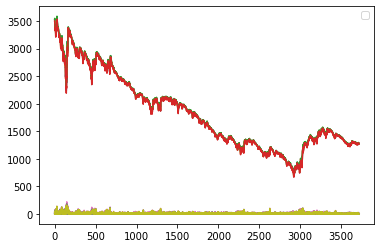

In [ ]:
start = 0
step = base_data.shape[0] #Сколько точек отрисуем
print('Сколько точек (шагов - минут) отрисуем = ',step)
"Plotim  4 канал"
plt.plot(base_data[start:start+step])
plt.legend()
plt.show()

In [ ]:
#Канал volume
print('Интревал рисуем , start + step', '\n' )
print('srart =', start, '\n')
print('step = ', step, '\n' )


Интревал рисуем , start + step 

srart = 0 

step =  3719 



In [ ]:
print('Формируем параметры загрузки данных')

Формируем параметры загрузки данных


In [ ]:
xLen = 24                     #Анализируем по 30 прошедшим точкам 
valLen = 2400                  #Используем 2000 записей для проверки

print('Делим данные на тренировочную и тестовую выборки')

trainLen = base_data.shape[0]-valLen
print('Размер тренировочной выборки =',trainLen )

xTrain,xTest = base_data[:trainLen], base_data[trainLen+xLen+2:]
print('Размер тестовой выборки =', trainLen+xLen+2 )

print('Для нормализации используем функцию MinMaxScaler()')
xScaler = MinMaxScaler()


print('Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке')

xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain =np.array(base_data.iloc[:trainLen, 1]).reshape(-1, 1)
yTest  =np.array(base_data.iloc[trainLen+xLen+2:, 1]).reshape(-1, 1)

print('Делаем reshape,т.к. у нас только один столбец по одному значению')
print('Делаем reshape для тренировочной и тестовой выборки')
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

print('Создаем генератор для обучения на xTrain (тренировочной выборке)  TimeseriesGenerator')
batch_size_my = int(input('Размер batch для xTrain = '))
trainDataGen = TimeseriesGenerator(xTrain, yTrain,                #В качестве параметров наши выборки
                                    length=xLen, stride=1,        #Для каждой точки (из промежутка длины xLen)
                                    batch_size=batch_size_my)     #Размер batch, который будем скармливать модели

batch_size_my = int(input('Размер batch для xTest = '))
print('Создаем аналогичный генератор для тестовой XTest выборке при обучении')
testDataGen = TimeseriesGenerator(xTest, yTest,
                               length=xLen, stride=1,
                               batch_size=batch_size_my)



Делим данные на тренировочную и тестовую выборки
Размер тренировочной выборки = 1319
Размер тестовой выборки = 1345
Для нормализации используем функцию MinMaxScaler()
Масштабируем данные (отдельно для X и Y), чтобы их легче было скормить сетке
Делаем reshape,т.к. у нас только один столбец по одному значению
Делаем reshape для тренировочной и тестовой выборки
Создаем генератор для обучения на xTrain (тренировочной выборке)  TimeseriesGenerator
Размер batch для xTrain = 20
Размер batch для xTest = 20
Создаем аналогичный генератор для тестовой XTest выборке при обучении


In [ ]:
testDataGen.data.shape

(2374, 9)

In [ ]:
trainDataGen.data.shape

(1319, 9)

Создаем нейронную сеть на 5000 нейронов  доп слой Dense, activation=linear
Компилируем, loss = mse, optimizer =1e-4
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 24, 1500)          9060000   
_________________________________________________________________
flatten_22 (Flatten)         (None, 36000)             0         
_________________________________________________________________
dense_42 (Dense)             (None, 10)                360010    
_________________________________________________________________
flatten_23 (Flatten)         (None, 10)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 11        
Total params: 9,420,021
Trainable params: 9,420,021
Non-trainable params: 0
___________________________________________________________

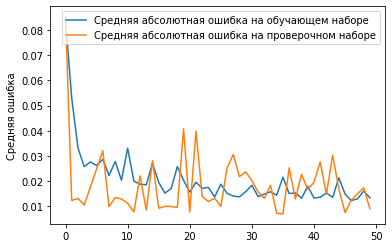

In [ ]:
print('Создаем нейронную сеть на 5000 нейронов  доп слой Dense, activation=linear')
modelD = Sequential()
modelD.add(LSTM(1500, input_shape = (xLen,9), activation="linear",return_sequences = True))
#modelD.add(Conv1D(1050,4, input_shape = (xLen,9), activation="linear"))

modelD.add(Flatten())

modelD.add(Dense(10, activation='linear')) 
#modelD.add(Dropout(0.9))
modelD.add(Flatten())
modelD.add(Dense(1, activation = "linear"))
print('Компилируем, loss = mse, optimizer =1e-4')
modelD.compile(loss="mae", optimizer=Adam(lr=1e-4))
modelD.summary()

print('Запускаем обучение')
#epochs = int(input('Введите количество эпох:'))
history = modelD.fit_generator(
                    trainDataGen, 
                    epochs=50, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

#Выводим графики Ждем.........................
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
print('Визуализация результатов')
print('Функция рассчитываем результаты прогнозирования сети')
print('Выдаёт результаты предсказания predVal')
print('И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)')
def getPred(currModel, xVal, yVal, yScaler):
 
 
  predVal = yScaler.inverse_transform(currModel.predict(xVal))  # Предсказываем ответ сети по проверочной выборке
  yValUnscaled = yScaler.inverse_transform(yVal)                # И возвращаем исходны масштаб данных, до нормализации
  
  return (predVal, yValUnscaled)

print('Функция визуализирует графики, что предсказала сеть и какие были правильные ответы')
print('start - точка с которой начинаем отрисовку графика')
print('step - длина графика, которую отрисовываем')
print('channel - какой канал отрисовываем')
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, 0],
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show() 


  # Функция расёта корреляции дух одномерных векторов
def correlate(a, b):
  # Рассчитываем основные показатели
  ma = a.mean() # Среднее значение первого вектора
  mb = b.mean() # Среднее значение второго вектора
  mab = (a*b).mean() # Среднее значение произведения векторов
  sa = a.std() # Среднеквадратичное отклонение первого вектора
  sb = b.std() # Среднеквадратичное отклонение второго вектора
  
  #Рассчитываем корреляцию
  val = 1
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

  # Функция рисуем корреляцию прогнозированного сигнала с правильным
# Смещая на различное количество шагов назад
# Для проверки появления эффекта автокорреляции
# channels - по каким каналам отображать корреляцию
# corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  # Проходим по всем каналам
  for ch in channels:
    corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно
    yLen = yValUnscaled.shape[0] # Запоминаем размер проверочной выборки

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, 0]))

    own_corr = [] # Создаём пустой лист, в нём будут корреляции при смезении на i рагов обратно

      # Постепенно увеличикаем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      # Получаем сигнал, смещённый на i шагов назад
      # predVal[i:, ch]
      # Сравниваем его с верными ответами, без смещения назад
      # yValUnscaled[:yLen-i,ch]
      # Рассчитываем их корреляцию и добавляем в лист
      own_corr.append(correlate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))

    # Отображаем график коррелций для данного шага
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

  #Создадим генератор проверочной выборки, из которой потом вытащим xVal, yVal для проверки
DataGen = TimeseriesGenerator(xTest, yTest,
                               length=24, stride=1,
                               batch_size=len(xTest)) #размер batch будет равен длине нашей выборки
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])

xVal = np.array(xVal)
yVal = np.array(yVal)

Визуализация результатов
Функция рассчитываем результаты прогнозирования сети
Выдаёт результаты предсказания predVal
И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
start - точка с которой начинаем отрисовку графика
step - длина графика, которую отрисовываем
channel - какой канал отрисовываем


# #Прогнозируем данные 


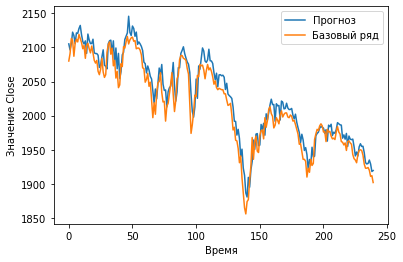

Реальный 2080     Прогноз  2105
Реальный 2091     Прогноз  2096
Реальный 2113     Прогноз  2105
Реальный 2110     Прогноз  2122
Реальный 2087     Прогноз  2117
Реальный 2106     Прогноз  2105
Реальный 2112     Прогноз  2121
Реальный 2108     Прогноз  2120
Реальный 2119     Прогноз  2127
Реальный 2113     Прогноз  2132
Реальный 2107     Прогноз  2118
Реальный 2098     Прогноз  2108
Реальный 2103     Прогноз  2104
Реальный 2084     Прогноз  2109
Реальный 2103     Прогноз  2091
Реальный 2106     Прогноз  2119
Реальный 2098     Прогноз  2111
Реальный 2092     Прогноз  2105
Реальный 2102     Прогноз  2105
Реальный 2092     Прогноз  2111
Реальный 2081     Прогноз  2091
Реальный 2077     Прогноз  2091
Реальный 2081     Прогноз  2090
Реальный 2065     Прогноз  2088
Реальный 2060     Прогноз  2070
Реальный 2068     Прогноз  2074
Реальный 2084     Прогноз  2085
Реальный 2064     Прогноз  2096
Реальный 2056     Прогноз  2073
Реальный 2060     Прогноз  2072
Реальный 2093     Прогноз  2068
Реальный

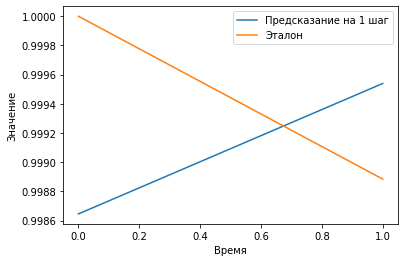

In [ ]:
#Прогнозируем данные текущей сетью Это то что сейчас. Стало хуже
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

#Отображаем графики
showPredict(0, 240, 0, predVal, yValUnscaled)
for i in range(240):
  y1 = yScaler.inverse_transform(yVal[0][i].reshape(-1,1))
  y2 = yScaler.inverse_transform(modelD.predict(xVal[0][i].reshape(1,24,9)))
  print( 'Реальный', int(y1[0][0]),'    Прогноз ', int(y2[0][0]))


#Отображаем корреляцию хотим улучшить 0.999 пока 0.997. стало 0.9992 
#Используем выходной канал - только open
#Проверяем корреляцию на глубину 60 шагов
showCorr([0],2     
         
         
         , predVal, yValUnscaled)

# Нейронка 2

Epoch 1/4
65/65 [==============================] - 2s 25ms/step - loss: 0.0119 - val_loss: 0.0241
Epoch 2/4
65/65 [==============================] - 1s 16ms/step - loss: 0.0060 - val_loss: 0.0122
Epoch 3/4
65/65 [==============================] - 1s 16ms/step - loss: 0.0038 - val_loss: 0.0130
Epoch 4/4
65/65 [==============================] - 1s 16ms/step - loss: 0.0026 - val_loss: 0.0075


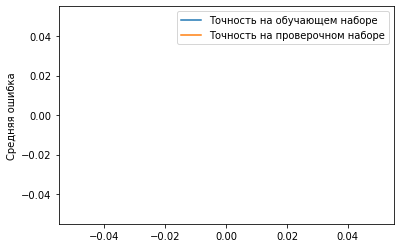

In [ ]:
dataInput = Input(shape=(xLen,9))

lstmWay = LSTM(40, return_sequences="True")(dataInput)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(dataInput)

lstmWay = LSTM(40, return_sequences="True")(lstmWay)
lstmWay = Dropout(0.3)(lstmWay)

convWay = Conv1D(100, 5, activation="relu")(convWay)

denseWay = Dense(10, activation="linear")(dataInput)
denseWay = Dense(10, activation="linear")(denseWay)

lstmWay = Flatten()(lstmWay)
convWay = Flatten()(convWay)
denseWay = Flatten()(denseWay)

finWay = concatenate([lstmWay, convWay, denseWay])
finWay = Dense(10, activation="linear")(finWay)
finWay = Dense(yTrain.shape[1], activation="linear")(finWay)

modelX3 = Model(dataInput, finWay)

modelX3.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelX3.fit_generator(
                    trainDataGen, 
                    epochs=4, 
                    verbose=1, 
                    validation_data = testDataGen 
                    )

plt.plot(history.history['loss'][10:], 
         label='Точность на обучающем наборе')
plt.plot(history.history['val_loss'][10:], 
         label='Точность на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
#Прогнозируем данные текущей сетью
currModel = modelX
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
#Отображаем графики
showPredict(0, 100, 0, predVal, yValUnscaled)

NameError: ignored

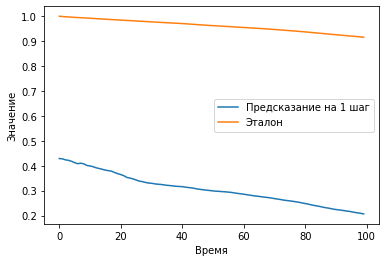

In [ ]:
#Отображаем корреляцию
showCorr([0], 100, predVal, yValUnscaled)